In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_gaussian_quantiles
import pandas as pd
import seaborn as sns
import ipdb
import copy
from bisect import bisect_left
import seaborn as sns

sns.set_style('darkgrid')

# Create dataset

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_2d(X, y, savepath=None, algorithm="tsne", title="Data in 2D", figsize=(8, 8)):
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA

    # Dimensionality reduction
    if algorithm == "tsne":
        reducer = TSNE(n_components=2, random_state=47, n_iter=400, angle=0.6)
    elif algorithm == "pca":
        reducer = PCA(n_components=2, random_state=47)
    else:
        raise ValueError("Unsupported dimensionality reduction algorithm given.")

    if X.shape[1] > 2:
        X = reducer.fit_transform(X)
    elif isinstance(X, pd.DataFrame):
        X = X.values

    # Creating a DataFrame for seaborn
    df = pd.DataFrame(X, columns=['Feature1', 'Feature2'])
    df['Label'] = y

    # Plotting
    f, ax1 = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    plt.xlim([-1.5, 2.2])
    plt.ylim([-1.5, 2.2])

    sns.scatterplot(data=df, x='Feature1', y='Feature2', hue='Label', ax=ax1, s=95)

    ax1.get_xaxis().set_ticklabels([])
    ax1.get_yaxis().set_ticklabels([])
    ax1.set_title(title)

    # Saving the plot if a path is provided
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')

    plt.Circle((0, 0), 0.5, color='b')
    plt.show()

# Example usage
# visualize_2d(X, y)


In [22]:
# def visualize_2d(X,y, savepath = None, algorithm="tsne",title="Data in 2D",figsize=(8,8)):
#     from sklearn.manifold import TSNE
#     from sklearn.decomposition import PCA
#     import pandas as pd

    
#     if algorithm=="tsne":
#         reducer = TSNE(n_components=2,random_state=47,n_iter=400,angle=0.6)
#     elif algorithm=="pca":
#         reducer = PCA(n_components=2,random_state=47)
#     else:
#         raise ValueError("Unsupported dimensionality reduction algorithm given.")
#     if X.shape[1]>2:
#         X = reducer.fit_transform(X)
#     else:
#         if type(X)==pd.DataFrame:
#         	X=X.values
#     f, (ax1) = plt.subplots(nrows=1, ncols=1,figsize=figsize)
#     plt.xlim([-1.5, 2.2])
#     plt.ylim([-1.5, 2.2])
    

    
#     #sns.jointplot(x=X[:,0], y=X[:,1], hue=y,ax=ax1, s = 95)
#     #a.ax_joint.plot([0],[0],'o',ms=60 , mec='r', mfc='none')
#     sns.scatterplot(X[:,0],X[:,1],hue=y,ax=ax1, s = 95);
#     ax1.get_xaxis().set_ticklabels([])
#     ax1.get_yaxis().set_ticklabels([])
#     #plt.grid()
#     #ax1.set_title(title);
#     if savepath:
#         plt.savefig(savepath, bbox_inches = 'tight')
#     plt.Circle((0, 0), 0.5, color='b')

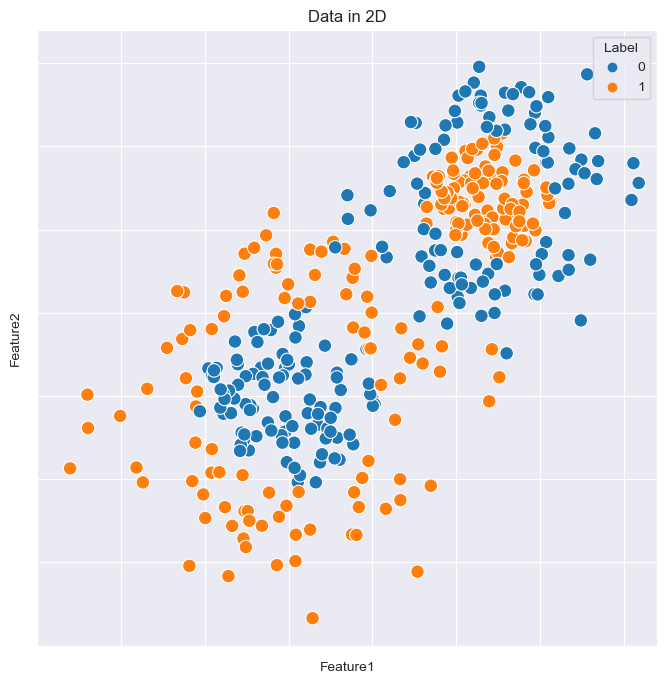

In [23]:
# Construct dataset
# Gaussian 1
Xg1, yg1 = make_gaussian_quantiles(cov=0.2,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=3)
Xg1 = pd.DataFrame(Xg1,columns=['x','y'])
yg1 = pd.Series(yg1)
# Gaussian 2
Xg2, yg2 = make_gaussian_quantiles(mean=(1.2, 1.2), cov=0.1,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=3)
Xg2 = pd.DataFrame(Xg2,columns=['x','y'])
yg2 = pd.Series(yg2)
# Combine the gaussians
Xg1.shape
Xg2.shape


Xg = pd.DataFrame(np.concatenate((Xg1, Xg2)))
yg = pd.Series(np.concatenate((yg1, - yg2 + 1)))
Xg.shape
visualize_2d(Xg,yg)

## Design submod and BP functions

In [24]:
Xg, yg = Xg.to_numpy(), yg.to_numpy()

In [25]:
affinity_mat = np.zeros((len(Xg), len(Xg)))

for i in range(len(Xg)):
    for j in range(i+1):
        if yg[i] != yg[j]:
            affinity_mat[i,j] = 1/np.linalg.norm(Xg[i] - Xg[j])
            affinity_mat[j,i] = 1/np.linalg.norm(Xg[i] - Xg[j])

In [26]:
def compute_diversity_gain(class_to_count, x_i, label_i):
    h = lambda x: np.sqrt(x)
    gain = h(class_to_count[label_i] + 1) - h(class_to_count[label_i])
    class_to_count[label_i] += 1
    return gain, class_to_count 

def BinarySearch(a, x):
    i = bisect_left(a, x)
    if i:
        return (i-1)
    else:
        return -1

def assign_to_box(x_i, hor_grid, vert_grid):
    hor = x_i[0]
    vert = x_i[1]
    num_hor, num_vert = len(hor_grid) - 1, len(vert_grid) - 1
    
    hor_res = BinarySearch(hor_grid, hor)
    vert_res = BinarySearch(vert_grid, vert)
    
    box = hor_res * num_vert + vert_res
    return box

def compute_box_submod_gain(box_to_count, box_to_count_gt, x_i, label_i, idx_to_box, mutate_flag):
    box = idx_to_box[x_i]
    empirical_count = box_to_count[box]
    empirical_count_gt = box_to_count_gt[box]
    
    gain = np.sqrt(empirical_count_gt[label_i])*(np.log(empirical_count[label_i] + 2) - np.log(1 + empirical_count[label_i]))
    
    if mutate_flag:
        empirical_count[label_i] += 1
        box_to_count[box] = empirical_count
    
    return gain, box_to_count

def compute_affinity_gain(sum_so_far, x_i, S_i, affinity_mat):
    affinity_mat_truncated = affinity_mat[:, S_i]
    relevant_row = affinity_mat_truncated[x_i]
    gain = np.sum(relevant_row)
    return gain, sum_so_far + gain

def compute_bp_gain(x_i, S_i, label_i, class_to_count, affinity_mat, sum_so_far, lambda_one):
    sub_gain, class_to_count = compute_diversity_gain(class_to_count, x_i, label_i)
    sup_gain, sum_so_far = compute_affinity_gain(sum_so_far, x_i, S_i, affinity_mat)
    return sub_gain + lambda_one*sup_gain, class_to_count, sum_so_far

def compute_bp_gain_box(x_i, S_i, label_i, box_to_count, box_to_count_gt, affinity_mat, 
                        sum_so_far, lambda_one, idx_to_box, mutate_flag = False):
    
    sub_gain, box_to_count = compute_box_submod_gain(box_to_count, box_to_count_gt, x_i, 
                                                     label_i, idx_to_box, mutate_flag)
    
    sup_gain, sum_so_far = compute_affinity_gain(sum_so_far, x_i, S_i, affinity_mat)
    return sub_gain + lambda_one*sup_gain, box_to_count, sum_so_far


# Run simulation and make plots

In [27]:
class Environment:

    def __init__(self, T, sigma, lambda_one_lst, recommender, ground_set, affinity_mat, labels, idx_to_box, box_to_count_gt, seed = 0):
        self.T = T
        self.sigma = sigma
        self.lambda_one_lst = lambda_one_lst
        self.recommender = recommender
        self.ground_set = ground_set
        self.labels = labels
        self.affinity_mat = affinity_mat
        self.idx_to_box = idx_to_box
        self.box_to_count_gt = box_to_count_gt
    
        
    def run_simulation(self):
        Si_lst = []
        yi_hist = []
        sub_hist = []
        sup_hist = []
        
        max_box = np.max(idx_to_box)
        box_to_count = {}

        for i in range(max_box +1):
            box_to_count[i] = [0, 0]

        #class_to_count[0] = 0
        #class_to_count[1] = 0
        sum_so_far = 0

        for i in range(self.T):
            
            lambda_one = self.lambda_one_lst[i]
            #Obtain recommendation from recommender
            x_i = self.recommender.get_next_item()
            print("Item chosen at round", i, ": ", x_i)
            label_i = self.labels[x_i]

            Si_lst.append(x_i)

            #This online computation helps speed up reward evaluation    
            sub_gain, box_to_count = compute_box_submod_gain(box_to_count, self.box_to_count_gt, 
                                                             x_i, label_i, idx_to_box, True)
            #sub_gain, box_to_count = compute_diversity_gain(class_to_count, x_i, label_i)
            sup_gain, sum_so_far = compute_affinity_gain(sum_so_far, x_i, Si_lst, self.affinity_mat)

            if i > 0:
                sub = sub_hist[-1] + sub_gain
                sup =  sup_hist[-1] + lambda_one*sup_gain
            else :
                sub, sup = sub_gain, lambda_one*sup_gain


            #Get reward
            y_i = sub_gain + lambda_one*sup_gain + self.sigma*np.random.normal()
            success = self.recommender.receive_reward(y_i)

            #Bookkeeping
            sub_hist.append(sub)
            sup_hist.append(sup)
            yi_hist.append(y_i)

        return Si_lst, yi_hist, sub_hist, sup_hist


## Run Greedy Algorithm for active learning

In [28]:
class GreedyBaseline:

    def __init__(self, T, lambda_one_lst, ground_set, affinity_mat, labels, box_to_count_gt, idx_to_box, seed = 0):

        self.T = T
        self.lambda_one_lst = lambda_one_lst
        self.ground_set = ground_set
        self.labels = labels
        self.affinity_mat = affinity_mat
        
        self.idx_to_box = idx_to_box
        self.box_to_count_gt = box_to_count_gt
        
        box_to_count = {}

        for i in range(max_box +1):
            box_to_count[i] = [0, 0]
        
        self.box_to_count = box_to_count

        #Record what is happening in the game
        class_to_count = {}
        class_to_count[0] = 0
        class_to_count[1] = 0
        self.class_to_count = class_to_count
        self.sum_so_far = 0
        self.yi_list = []
        self.selected = []

    def get_next_item(self):

        potential_gains = []
        i = len(self.selected)
        lambda_one = self.lambda_one_lst[i]

        for item in self.ground_set:
            if item in self.selected:
                potential_gains.append(0)
                continue
            else :                
                class_to_count_copy = copy.deepcopy(self.class_to_count)
                sum_so_far_copy = self.sum_so_far

    
                gain, box_to_count, sum_so_far = compute_bp_gain_box(item, self.selected, self.labels[item], 
                                                                     self.box_to_count, self.box_to_count_gt, 
                                                                     self.affinity_mat, sum_so_far_copy, lambda_one, 
                                                                     self.idx_to_box, mutate_flag = False)
                
                """
                gain, box_to_count, sum_so_far = compute_bp_gain(item, self.selected, self.labels[item], 
                                                           class_to_count_copy, self.affinity_mat, 
                                                           sum_so_far_copy, self.lambda_one)
                """
                potential_gains.append(gain)
                

        selected = np.argmax(potential_gains)
        self.selected.append(selected)
        
        
        gain, box_to_count, sum_so_far = compute_bp_gain_box(selected, self.selected, self.labels[selected], 
                                                                     self.box_to_count, self.box_to_count_gt, 
                                                                     self.affinity_mat, 
                                                                     self.sum_so_far, lambda_one, 
                                                                     self.idx_to_box, mutate_flag = True)
        
        """
        gain, class_to_count, sum_so_far = compute_bp_gain(selected, self.selected, self.labels[selected], 
                                                           self.class_to_count, self.affinity_mat, 
                                                           self.sum_so_far, self.lambda_one)
        """
    
        
        self.box_to_count, self.sum_so_far = box_to_count, sum_so_far
        return selected

    def receive_reward(self, yi):
        self.yi_list.append(yi)
        return True

In [29]:
hor_grid = np.linspace(-1.6, 2.5, 9)
vert_grid = np.linspace(-1.6, 2.5, 9)
idx_to_box = []

for x in Xg:
    box = assign_to_box(x, hor_grid, vert_grid)
    idx_to_box.append(box)

In [30]:
#TODO: Calculate box to count gt
max_box = np.max(idx_to_box)
box_to_count = {}

for i in range(max_box +1):
    box_to_count[i] = [0, 0]

for (idx, box_identity) in enumerate(idx_to_box):
    label = yg[idx]
    box_to_count[box_identity][label] += 1

In [31]:
# Configurations

_T = 100
_lambda_one_lst = [0.005 for i in range(int(_T/2))] + [0.005 for i in range(int(_T/2))]
_lambda_one_lstV2 = [0 for i in range(int(_T/2))] + [0 for i in range(int(_T/2))]


_sigma = 0.1
_ground_set = np.arange(len(Xg))
_labels = yg
_affinity_mat = affinity_mat

In [32]:
greedy_rec = GreedyBaseline(_T, _lambda_one_lst, _ground_set, _affinity_mat, _labels, box_to_count, idx_to_box)
greedy_env = Environment(_T, _sigma, _lambda_one_lst, greedy_rec, _ground_set, 
                         _affinity_mat, _labels, idx_to_box, box_to_count)

In [33]:
greedy_recV2 = GreedyBaseline(_T, _lambda_one_lstV2, _ground_set, _affinity_mat, _labels, box_to_count, idx_to_box)
greedy_envV2 = Environment(_T, _sigma, _lambda_one_lstV2, greedy_recV2, _ground_set, 
                         _affinity_mat, _labels, idx_to_box, box_to_count)

In [34]:
ret_greedyV2 = greedy_envV2.run_simulation()

Item chosen at round 0 :  203
Item chosen at round 1 :  4
Item chosen at round 2 :  3
Item chosen at round 3 :  202
Item chosen at round 4 :  205
Item chosen at round 5 :  9
Item chosen at round 6 :  221
Item chosen at round 7 :  8
Item chosen at round 8 :  189
Item chosen at round 9 :  15
Item chosen at round 10 :  6
Item chosen at round 11 :  208
Item chosen at round 12 :  10
Item chosen at round 13 :  13
Item chosen at round 14 :  210
Item chosen at round 15 :  21
Item chosen at round 16 :  201
Item chosen at round 17 :  204
Item chosen at round 18 :  244
Item chosen at round 19 :  7
Item chosen at round 20 :  5
Item chosen at round 21 :  249
Item chosen at round 22 :  206
Item chosen at round 23 :  0
Item chosen at round 24 :  233
Item chosen at round 25 :  247
Item chosen at round 26 :  209
Item chosen at round 27 :  22
Item chosen at round 28 :  49
Item chosen at round 29 :  200
Item chosen at round 30 :  212
Item chosen at round 31 :  266
Item chosen at round 32 :  16
Item chose

In [35]:
ret_greedy = greedy_env.run_simulation()

Item chosen at round 0 :  203
Item chosen at round 1 :  18
Item chosen at round 2 :  171
Item chosen at round 3 :  376
Item chosen at round 4 :  386
Item chosen at round 5 :  25
Item chosen at round 6 :  288
Item chosen at round 7 :  8
Item chosen at round 8 :  189
Item chosen at round 9 :  115
Item chosen at round 10 :  176
Item chosen at round 11 :  75
Item chosen at round 12 :  395
Item chosen at round 13 :  382
Item chosen at round 14 :  13
Item chosen at round 15 :  296
Item chosen at round 16 :  264
Item chosen at round 17 :  228
Item chosen at round 18 :  385
Item chosen at round 19 :  36
Item chosen at round 20 :  185
Item chosen at round 21 :  7
Item chosen at round 22 :  65
Item chosen at round 23 :  365
Item chosen at round 24 :  314
Item chosen at round 25 :  243
Item chosen at round 26 :  253
Item chosen at round 27 :  236
Item chosen at round 28 :  275
Item chosen at round 29 :  79
Item chosen at round 30 :  214
Item chosen at round 31 :  88
Item chosen at round 32 :  315

## Plotting and visualization

In [36]:
def make_yi_hist_plot(ret, T, title, title_flag):
    yi_hist = ret[1]
    yi_cumul = np.cumsum(yi_hist)
    plt.plot(np.arange(len(yi_cumul)), yi_cumul, label = "noisy total rewards")

    if title_flag:
        plt.title(title)
    plt.legend()
    return True

def make_sub_sup_split_plot_v2(ret, title, title_flag):
    Si_dict = ret[0]
    single_sub_hist = ret[-2]
    single_sup_hist = ret[-1]
    

    plt.plot(np.arange(len(single_sub_hist)), single_sub_hist, '--', label = title + 'submod')
    plt.plot(np.arange(len(single_sup_hist)), single_sup_hist, label = title+ 'supermod')
    
    if title_flag:
        plt.title(title)
    plt.legend()
    return True

In [37]:
make_yi_hist_plot(ret_greedy, _T, '', True)
make_sub_sup_split_plot_v2(ret_greedy, '', False)

True

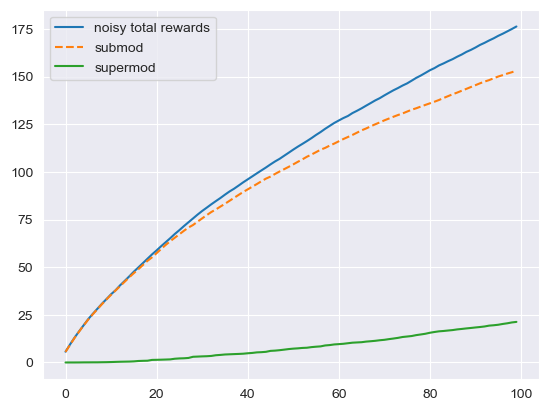

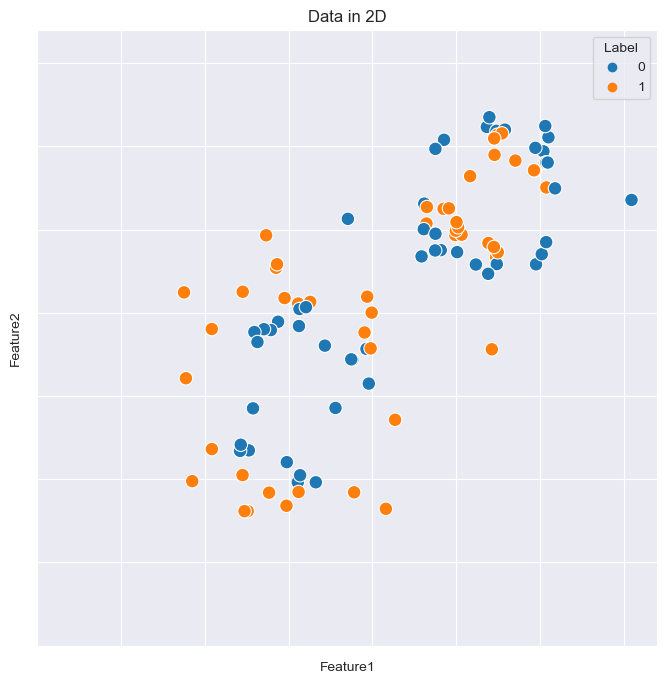

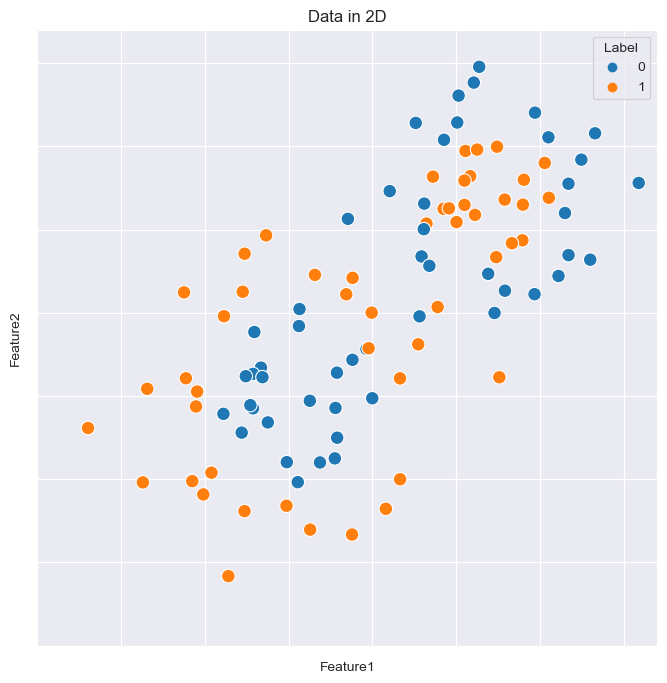

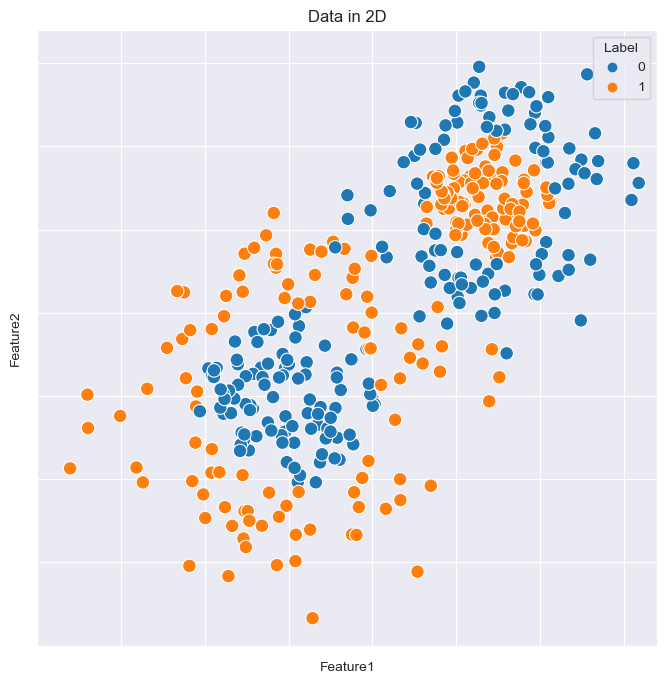

In [38]:
selected_idx = ret_greedy[0]
X_plot = Xg[selected_idx]
y_plot = yg[selected_idx]

selected_idx = ret_greedyV2[0]
X_plot_submod = Xg[selected_idx]
y_plot_submod = yg[selected_idx]


visualize_2d(X_plot, y_plot, savepath = None)
visualize_2d(X_plot_submod, y_plot_submod, savepath = None)
visualize_2d(Xg,yg, savepath = None)